In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import load_mpl_presets, mpl_loc, fancy_legend, named_colors
import numpy as np
import vice
import sys
import os
print(sys.version_info)
load_mpl_presets()

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [7]:
vice.yields.ccsne.settings['o'] = 0.015
vice.yields.sneia.settings['o'] = 0
vice.yields.ccsne.settings['fe'] = 0.0012
vice.yields.sneia.settings['fe'] = 0.00214

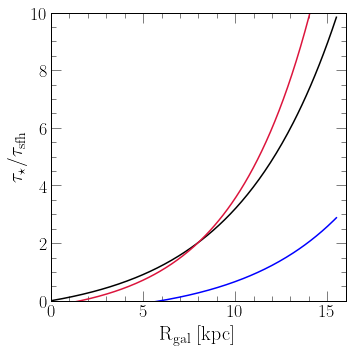

In [8]:
fig = plt.figure(figsize = (5, 5), facecolor = "white")
ax = fig.add_subplot(111)
ax.set_xlabel(r"R$_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_\star / \tau_\text{sfh}$")
ax.set_xlim([0, 16])
ax.set_ylim([0, 10])

def taustar_on_tausfh(rgal, slope = -0.08, yocc = 0.015):
    Z_oxygen = 10**(slope * (rgal - 8)) * vice.solar_z['o']
    return yocc / Z_oxygen - 1 + 0.4

xvals = np.linspace(0, 15.5, 200)
yvals = [taustar_on_tausfh(_) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["black"])

yvals = [taustar_on_tausfh(_, slope = -0.1) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

yvals = [taustar_on_tausfh(_, yocc = 0.005) for _ in xvals]
ax.plot(xvals, yvals, c = named_colors()["blue"])

plt.tight_layout()
plt.show()

In [9]:
class exponential:
    
    def __init__(self, norm = 10, timescale = 1):
        self.norm = norm
        self.timescale = timescale
        
    def __call__(self, x):
        return self.norm * np.exp(-x / self.timescale)
    
class linear_exponential(exponential):
    
    def __call__(self, x):
        return x * super().__call__(x)

7.25


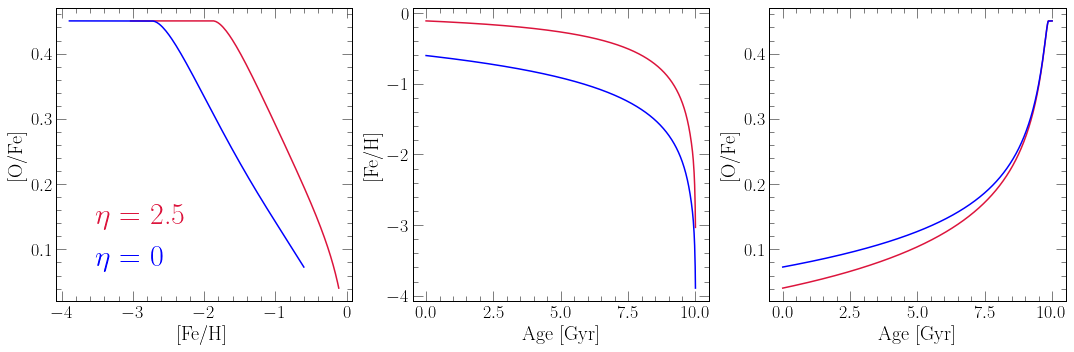

In [24]:
fig = plt.figure(figsize = (15, 5), facecolor = "white")
axes = []
xlabels = ["[Fe/H]", "Age [Gyr]", "Age [Gyr]"]
ylabels = ["[O/Fe]", "[Fe/H]", "[O/Fe]"]
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel(ylabels[i])

with vice.singlezone(name = "tmp") as sz:
    sz.func = exponential(timescale = 50)
    sz.mode = "sfr"
    sz.tau_star = 10
    out = sz.run(np.linspace(0, 10, 1001), capture = True, overwrite = True)
    kwargs = {
        "c": named_colors()["crimson"],
        "label": r"$\eta$ = %g" % (sz.eta)
    }
    axes[0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)
    axes[1].plot(out.history["lookback"], out.history["[fe/h]"], **kwargs)
    axes[2].plot(out.history["lookback"], out.history["[o/fe]"], **kwargs)
    factor = (1 + sz.eta - 0.4 - sz.tau_star / sz.func.timescale) / (1 - 0.4 - sz.tau_star / sz.func.timescale)
    factor = abs(factor)
    print(factor)

with vice.singlezone(name = "tmp") as sz:
    vice.yields.ccsne.settings['o'] /= factor
    vice.yields.ccsne.settings['fe'] /= factor
    vice.yields.sneia.settings['fe'] /= factor
    sz.func = exponential(timescale = 50)
    sz.mode = "sfr"
    sz.eta = 0
    sz.tau_star = 10
    out = sz.run(np.linspace(0, 10, 1001), capture = True, overwrite = True)
    kwargs = {
        "c": named_colors()["blue"],
        "label": r"$\eta$ = %g" % (sz.eta)
    }
    axes[0].plot(out.history["[fe/h]"], out.history["[o/fe]"], **kwargs)
    axes[1].plot(out.history["lookback"], out.history["[fe/h]"], **kwargs)
    axes[2].plot(out.history["lookback"], out.history["[o/fe]"], **kwargs)
    vice.yields.ccsne.settings['o'] *= factor
    vice.yields.ccsne.settings['fe'] *= factor
    vice.yields.sneia.settings['fe'] *= factor
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "bbox_to_anchor": (0.01, 0.01),
    "fontsize": 30
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

plt.tight_layout()
plt.show()

In [15]:
class analytic_Zalpha:
    
    def __init__(self, y_alpha = 0.015, taurise = 2, tausfh = 6, taustar = 5, eta = 2.5, recycling = 0.4):
        self.y_alpha = y_alpha
        self.taurise = taurise
        self.tausfh = tausfh
        self.taustar = taustar
        self.eta = eta
        self.recycling = recycling
        
    def __call__(self, time):
        if time == 0: return 0
        term1 = 1 / (1 - np.exp(-time / self.taurise))
        term2 = self.y_alpha / (1 + self.eta - self.recycling)
        term3 = self.tausfh / (self.tausfh - self.taudep) * (
            1 - np.exp(-time * (self.tausfh - self.taudep) / (self.tausfh * self.taudep)))
        term4 = self.tausfh * self.taurise / (self.tausfh * self.taurise - self.taudep * self.taurise -
            self.tausfh * self.taudep) * (
                np.exp(-time / self.taurise) -
                np.exp(-time * (self.tausfh - self.taudep) / (self.tausfh * self.taudep))
            )
        return term1 * term2 * (term3 - term4)

    @property
    def taudep(self):
        return self.taustar / (1 + self.eta - self.recycling)

In [19]:
test = analytic_Zalpha()
print(test(10))

0.006331620458450685


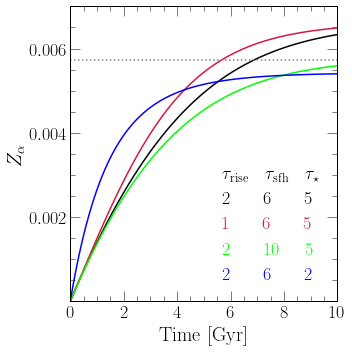

In [100]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("Time [Gyr]")
ax.set_ylabel(r"$Z_\alpha$")
ax.set_xlim([0, 10])
ax.set_ylim([0, 0.007])
ax.set_xticks(range(0, 11, 2))
ax.set_yticks([0.002, 0.004, 0.006])

kwargs = {
    "c": named_colors()["white"],
    "label": r"$\tau_\text{rise}$\quad$\tau_\text{sfh}$\quad$\tau_\star$"
}
ax.plot([-1, 0], [-1, 0], **kwargs)

model = analytic_Zalpha()

# taurise, tausfh, taustar
kwargs["c"] = named_colors()["black"]
kwargs["label"] = "2\qquad6\qquad5"
xvals = np.linspace(0, 10, 101)
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

model.taurise = 1
kwargs["c"] = named_colors()["crimson"]
kwargs["label"] = "1\qquad6\qquad5"
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

model.taurise = 2
model.tausfh = 10
kwargs["c"] = named_colors()["lime"]
kwargs["label"] = "2\qquad10\quad\;\;5"
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

model.tausfh = 6
model.taustar = 2
kwargs["c"] = named_colors()["blue"]
kwargs["label"] = "2\qquad6\qquad2"
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

# model.taustar = 5
# model.eta = 5
# kwargs["c"] = named_colors()["darkviolet"]
# kwargs["label"] = "2~~~~~6~~~~~5~~~~~5"
# yvals = [model(x) for x in xvals]
# ax.plot(xvals, yvals, **kwargs)

ax.axhline(vice.solar_z['o'], linestyle = ':', c = named_colors()["grey"])

kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.99, 0.01),
    "ncol": 1
}
leg = ax.legend(**kwargs)
for i in range(1, 5):
    leg.get_texts()[i].set_color(["black", "crimson", "lime", "blue"][i - 1])
    leg.legendHandles[i].set_visible(False)

plt.tight_layout()
plt.savefig("../latex/onezone-mdfs/vartimescales.pdf")
plt.show()

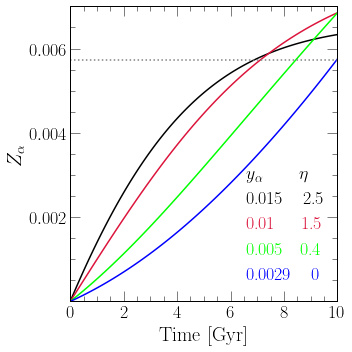

In [101]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("Time [Gyr]")
ax.set_ylabel(r"$Z_\alpha$")
ax.set_xlim([0, 10])
ax.set_ylim([0, 0.007])
ax.set_xticks(range(0, 11, 2))
ax.set_yticks([0.002, 0.004, 0.006])

kwargs = {
    "c": named_colors()["white"],
    "label": r"$y_\alpha$\qquad\:$\eta$"
}
ax.plot([-1, 0], [-1, 0], **kwargs)

model = analytic_Zalpha()

benchmark = 0.015 / (1 + 2.5 - 0.4) # y / (1 + \eta - r)

kwargs["c"] = named_colors()["black"]
kwargs["label"] = "0.015\quad\,2.5"
xvals = np.linspace(0, 10, 101)
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

kwargs["c"] = named_colors()["crimson"]
model.y_alpha = 0.01
model.eta = 0.01 / benchmark - (1 - 0.4)
kwargs["label"] = "0.01\quad\;\;%.1f" % (model.eta)
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

kwargs["c"] = named_colors()["lime"]
model.y_alpha = 0.005
model.eta = 0.005 / benchmark - (1 - 0.4)
kwargs["label"] = "0.005\quad%.1f" % (model.eta)
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

kwargs["c"] = named_colors()["blue"]
model.y_alpha = benchmark * (1 - 0.4)
kwargs["label"] = "%.4f\quad\,0" % (model.y_alpha)
model.eta = 0
yvals = [model(x) for x in xvals]
ax.plot(xvals, yvals, **kwargs)

ax.axhline(vice.solar_z['o'], linestyle = ':', c = named_colors()["grey"])

kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "bbox_to_anchor": (1.01, 0.01)
}
leg = ax.legend(**kwargs)
for i in range(5):
    if i: leg.get_texts()[i].set_color(["black", "crimson", "lime", "blue"][i - 1])
    leg.legendHandles[i].set_visible(False)

plt.tight_layout()
plt.savefig("../latex/onezone-mdfs/varyieldeta.pdf")
plt.show()